## Homework Goal

The goal of this homework is to do <span style="background-color:yellow"> linear regression </span> on Boston's house prices. After our training, we will have a model that can take in several attributes that may be related to house prices in Boston and give a prediction about the cost of this house.


## Input Data Description
<ul>
The dataset is available in scikit-learn under <span style="background-color:yellow"> sklearn.datasets </span> as load_boston.
The data include...
<li> total number of 506 cases
<li> each case has 13 attributes that is relavent to the house price and
<li> 1 target attribute: house price in some unit
<ul>

In [256]:
#Load the dataset using sklearn.datasets and parse using pandas and numpy

#import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
#y = np.zeros(506,)
#y[0:100] = 1
print(load_boston)
print(X.shape)
print(y.shape)
print(y[0:5])
print(X[1])


<function load_boston at 0x10dee3730>
(506, 13)
(506,)
[24.  21.6 34.7 33.4 36.2]
[2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
 7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
 9.1400e+00]


In [257]:
k=np.array([[1,2,3,3], [3,6,7,8]])
print(k.shape)

(2, 4)


In [258]:
#randomly split the data set into train set and test set
#test_size: portion of data set being used, random_state: randomizer we use
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(type(y_test[6]))
#How do the splitter decide the ratio of data set in train and test set?


(455, 13)
(51, 13)
<class 'numpy.float64'>


In [259]:
from sklearn.metrics import mean_squared_error
import time
import xgboost as xgb
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
#nthread is relavent to parallel computing and (seed is used to generate the fold randomly for cross validation of 
#in/ out sample error), n_estimators is the number of boosted trees
XGBregressor = xgb.sklearn.XGBRegressor(n_estimators=500, booster='gbtree', max_depth=4, learning_rate=0.01,\
                                        min_child_weight=2)
#Train and time regressor
start_time = time.time()
XGBregressor.fit(X_train, y_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBregressor.predict(X_test)

#Print Results
#print("Model Accuracy with all features: {:.2f}%".format(100*XGBregressor.score(X_test, y_test)))
print("The mean_squared_error of prediction is {:.2f}".format(mean_squared_error(y_test,y_pred)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))

Training on 455 examples with 13 features
Predicting on 51 examples with 13 features

The mean_squared_error of prediction is 7.64
Run time with all features: 0.26 sec




## Problems
<ul>
<li>After searching through some literatures, I found that the boost mechanism can also be used for linear regression via changing classifiers to linear functions. The XGBoost webpage also have descriptions about setting the learner to be linear HOWEVER it says that in this case, there will be no 'feature importances' which make sense. 
(cf.  https://xgboost.readthedocs.io/en/latest/python/python_api.html  property feature_importances_) 
<li>However, I still find some other boosting package such as sklearn ensemble that can compute feature importances for linear regression model which I find strange. 
(c.f. https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py )
<li>Next question now: how is there still <span style="background-color:yellow"> feature_ importances </span> instead of <span style="background-color:yellow"> coef_ attribute </span> in sklearn linear regression model? 
<li>I see... It's a problem of API of XGBoost. In 'XGBClassifier' one can only train logistic regression, while for 'XGBRegressor', one can do linear regression with gradient boost.
<ul>

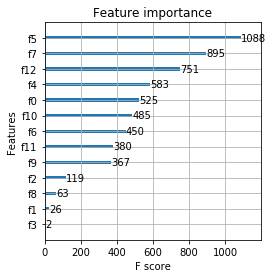

In [260]:
import matplotlib as mpl
import matplotlib.pyplot as plt


%matplotlib inline  

fig=plt.figure()
xgb.plot_importance(XGBregressor, ax=plt.gca())
fig.subplots_adjust(left=0.4)

## SelectFromModel select important features 

In [261]:
#pruning features in model with SelectFromModel
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(XGBregressor, threshold=0.01)

#train
sfm.fit(X_train, y_train)

SelectFromModel(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints=None,
                                       learning_rate=0.01, max_delta_step=0,
                                       max_depth=4, min_child_weight=2,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=500, n_jobs=0,
                                       num_parallel_tree=1,
                                       objective='reg:squarederror',
                                       random_state=0, reg_alpha=0,
                                       reg_lambda=1, scale_pos_weight=1,
                                       subsample=1, tree_method=None,
 

In [262]:

n_features = sfm.transform(X_train).shape[1]

#prune training data
print('number of features after pruning: ', n_features)
pruned_X_train = sfm.transform(X_train)

#Train and time regressor with data after pruning the features
start_time = time.time()
XGBregressor.fit(pruned_X_train, y_train)
run_time = time.time() - start_time

#prune testing data
pruned_X_test = sfm.transform(X_test)

#Make Predictions
print("Predicting on %i examples with %i features\n"%pruned_X_test.shape)
y_pred= XGBregressor.predict(pruned_X_test)

#Print Results
#print("Model Accuracy with all features: {:.2f}%".format(100*XGBregressor.score(X_test, y_test)))
print("The mean_squared_error of prediction is {:.2f}".format(mean_squared_error(y_test,y_pred)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))

#Print Results
#print("The mean_squared_error of prediction is {:.2f}".format(mean_squared_error(y_test,y_pred)))
#print("Run time with all features: {:.2f} sec\n\n".format(run_time))

number of features after pruning:  10
Predicting on 51 examples with 10 features

The mean_squared_error of prediction is 7.42
Run time with all features: 0.24 sec




## Analysis
The error after pruning the training features has slightly decrease, which is desired. //ignore the following //I think this may due to there exists better choice of hyperparameter for this particular set of features. To deal with this problem and decrease the error, we can use GridSearchCV to do the hyperparameter tuning. But, GridSearchCV seems to do hyperparameter testing with 'model' itself , which is irrelavent to the 'input data'. Or, the optimization actually start at .fit()? if so, then the grid search has take the training data into account. and the error should drop.

In [263]:
from sklearn.model_selection import GridSearchCV
#Create values to search over
cv_params = {'max_depth': [2,3,4], 'min_child_weight': [3,4,5], 'learning_rate':[0.18,0.2,0.22]}
ind_params = {'n_estimators': 100, 'seed':1, 'colsample_bytree': 1}
#**ind_params
opt_XGBregressor = GridSearchCV(xgb.XGBRegressor(), 
                             cv_params, 
                             scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1, verbose=3)

#opt_XGBregressor.get_params()
opt_XGBregressor.fit(pruned_X_train, y_train)
#sorted(opt_XGBregressor.cv_results_.keys())

#get the best params
print(opt_XGBregressor.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.0s


{'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 4}


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.9s finished


In [264]:
y_pred= opt_XGBregressor.predict(pruned_X_test)

#Print Results
print("The mean_squared_error of prediction is {:.2f}".format(mean_squared_error(y_test,y_pred)))
#print("Run time with all features: {:.2f} sec\n\n".format(run_time))
#8.07(un-pruned)-> 8.26(pruned)->8.26(take out ind_params)

The mean_squared_error of prediction is 7.68


## Conclusion
1. The error after pruning (13 features-->5 features): 7.64-->7.42 decreased 
2. The error after GridSearchCV(with pruned features): 7.64-->7.68 increased. 

Given the abouve facts, it is only possible to explain that the methond of "optimized by cross-validated" is not good enough compared to the hyperparameters found by this reference. https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py And is certainly not simply training with {given hyperparameters, all training data} and compare the error. I look up for explanation of cross validation in this reference. https://medium.com/@chih.sheng.huang821/交叉驗證-cross-validation-cv-3b2c714b18db